In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import masking
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, view_img
import os, sys
from config import Config
from pathlib import Path
from nilearn.image import mean_img
from nilearn.image import resample_to_img
import warnings
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.ndimage import median_filter
import statistics

In [2]:
def remove_background(mask, anat_file, bold_data):
    mask_in_run1_img = resample_to_img(source_img=mask, target_img=anat_file, interpolation='nearest')
    anat_data = anat_file.get_fdata()
    valid_run1 = np.isfinite(anat_data) & (anat_data != 0)
    mask_in_run1 = mask_in_run1_img.get_fdata().astype(bool)
    combined_mask = mask_in_run1 & valid_run1
    mask_4d = combined_mask[..., np.newaxis]

    bold_data_masked = bold_data * mask_4d
    active_voxels = np.any(bold_data_masked != 0, axis=-1)  
    final_mask = active_voxels & combined_mask
    masked_timeseries_3d = np.where(final_mask[..., None], bold_data, 0)

    active_voxels = np.any(masked_timeseries_3d != 0, axis=-1)
    coords = np.array(np.where(active_voxels)).T
    xmin, ymin, zmin = coords.min(axis=0)
    xmax, ymax, zmax = coords.max(axis=0)
    # crop to bounding box
    masked_timeseries_3d_cropped = masked_timeseries_3d[xmin:xmax+1, ymin:ymax+1, zmin:zmax+1, :]
    return masked_timeseries_3d_cropped, xmin, ymin, zmin


def save_beta_html(beta_3d, anat_img, bold_img, A, title, fname):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*symmetric_cmap=False.*", category=UserWarning)
        warnings.filterwarnings("ignore", message=".*vmin cannot be chosen when cmap is symmetric.*", category=UserWarning)

    finite = np.isfinite(beta_3d)
    beta_filled = np.where(finite, beta_3d, 0.0)
    
    # keep NaNs — they’ll be transparent
    finite = np.isfinite(beta_3d)
    if not np.any(finite):
        raise ValueError("No finite values to display.")
    
    vmax = np.nanpercentile(beta_filled[finite], 99)  
    vmin = np.nanpercentile(beta_filled[finite], 1)
    print(f"vmin: {vmin}, vmax:{vmax}")
    thr = 1e-6 

    beta_on_anat = nib.Nifti1Image(beta_3d, A, bold_img.header)
    
    view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr, 
                    colorbar=True, title=title)
    view.save_as_html(file_name=fname)

# def robust_vrange(img, lo=1, hi=99):
#     data = np.asarray(img.get_fdata(), dtype=float)
#     data = data[np.isfinite(data)]
#     if data.size == 0:
#         return 0.0, 1.0
#     vmin, vmax = np.percentile(data, [lo, hi])
#     return float(vmin), float(vmax)

def plot_beta_hist(beta_value, xlim_range=None, title=None):
    plt.figure()
    plt.hist(beta_value.ravel(), bins=10)
    plt.xlabel('Beta Value')
    plt.ylabel('Count')
    if xlim_range:
        plt.xlim(xlim_range)
    if title:
        plt.title(title)
    plt.show()

fmt = lambda x: f"{x:.3f}"
fmt_arr = lambda a: np.array2string(np.asarray(a), precision=3, separator=', ', suppress_small=True)


In [3]:
ses = 1
sub = '04'
run = 1

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
mask = nib.load(mask_path)

print(anat_img.shape)
print(bold_data.shape)
print(mask.shape)

(90, 128, 85)
(90, 128, 85, 850)
(180, 256, 170)


In [4]:
# plot bold on anat
view = view_img(mean_img(bold_img), bg_img=anat_img, cmap='seismic', symmetric_cmap=False, colorbar=True)
view.save_as_html(file_name='Bold_on_Anat.html')

/tmp/ipykernel_321280/206324395.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  view = view_img(mean_img(bold_img), bg_img=anat_img, cmap='seismic', symmetric_cmap=False, colorbar=True)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
glm_dict = np.load('/home/zkavian/thesis_code_git/GLMOutputs-sub04-ses1/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[..., :90], beta_glm[..., 90:]
R2_run1, R2_run2 = glm_dict['R2run'][:,:,:,0], glm_dict['R2run'][:,:,:,1]

beta = beta_run1
R2 = R2_run1

masked_bold_data, xmin, ymin, zmin = remove_background(mask, anat_img, bold_data)
print(masked_bold_data.shape)
A = bold_img.affine.copy()
A[:3, 3] = A[:3, 3] + A[:3, :3] @ np.array([xmin, ymin, zmin], dtype=float)


# beta_img_can = nib.Nifti1Image(glm_dict['betasmd'].astype(np.float32),
#                                bold_can.affine, bold_can.header)
# beta_img_in_bold = resample_to_img(beta_img_can, bold_img_run1, interpolation='continuous')
# betas_in_bold = beta_img_in_bold.get_fdata() 

/tmp/ipykernel_324750/94407561.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mask_in_run1_img = resample_to_img(source_img=mask, target_img=anat_file, interpolation='nearest')
/tmp/ipykernel_324750/94407561.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_in_run1_img = resample_to_img(source_img=mask, target_img=anat_file, interpolation='nearest')


(69, 92, 73, 850)


In [6]:
bold_img_masked = nib.Nifti1Image(masked_bold_data, A)
bold_mean_masked = mean_img(bold_img_masked, copy_header=True)
view = view_img(bold_mean_masked, bg_img=anat_img, title='Masked BOLD Image on Anatomic Brain')
view.save_as_html(f"Masked_BOLD_data_on_anat_sub{sub}_ses{ses}_run{run}.html")

save_beta_html(np.nanmean(beta, axis=-1), anat_img, bold_img, A, '', fname = f"Masked_beta{sub}_ses{ses}_run{run}.html")

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_319983/1288270985.py:6: RuntimeWarning: Mean of empty slice
  save_beta_html(np.nanmean(beta, axis=-1), anat_img, bold_img, A, '', fname = f"Masked_beta{sub}_ses{ses}_run{run}.html")
/tmp/ipykernel_319983/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWar

vmin: -2.888521671295166, vmax:2.661463499069214


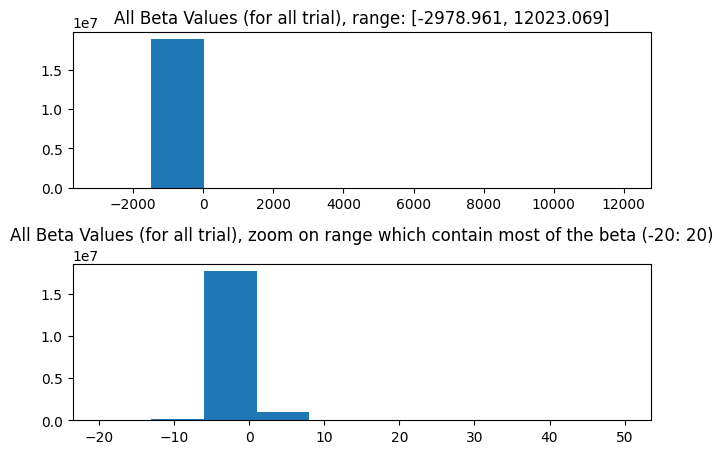

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].hist(beta.ravel(), bins=10)
ax[0].set_title(f"All Beta Values (for all trial), range: [{fmt(np.nanmin(beta.ravel()))}, {fmt(np.nanmax(beta.ravel()))}]")

zoom_mask = (-20 <= beta) & (beta <= 50)
ax[1].hist(beta[zoom_mask].ravel(), bins=10)
# ax[1].set_xlim() #(1500, 20)
ax[1].set_title("All Beta Values (for all trial), zoom on range which contain most of the beta (-20: 20)")

plt.tight_layout()
plt.show()

In [8]:
#hist beta of voxels which have high beta
mask = np.where(abs(beta)>=20)
coords = np.column_stack(mask[:3])
unique_coords = np.unique(coords, axis=0)
# print(unique_coords)

In [9]:
print(f"{fmt(unique_coords.shape[0]/beta[:3].size*100)}% of voxels have abs(beta) value higher than 20.")
print(f"{fmt(np.where(mask)[0].shape[0]/beta.size*100)}% of trials have abs(beta) value higher than 20.")

0.697% of voxels have abs(beta) value higher than 20.
0.471% of trials have abs(beta) value higher than 20.


In [10]:
beta_thr = 20  
beta_new = np.full_like(beta, np.nan, dtype=float)
beta_mask = np.abs(beta) >= beta_thr
beta_new[beta_mask] = beta[beta_mask]

mask3d = np.any(beta_mask, axis=-1)
beta_summary = np.nanmean(beta_new, axis=-1)
beta_3d = np.where(mask3d, beta_summary, np.nan)


title = f"Voxels with |beta| >= {beta_thr}"
fname = f"HighLow_beta_thr{beta_thr}_sub{sub}_ses{ses}_run{run}.html"
save_beta_html(beta_3d, anat_img, bold_img, A, title, fname)

/tmp/ipykernel_319983/3215622337.py:7: RuntimeWarning: Mean of empty slice
  beta_summary = np.nanmean(beta_new, axis=-1)
/tmp/ipykernel_319983/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition

vmin: -336.05652587890626, vmax:320.15985961914055


-2978.9607 12023.069
Axes(0.125,0.653529;0.227941x0.226471) 1 47 34
Axes(0.398529,0.653529;0.227941x0.226471) 2 57 28
Axes(0.672059,0.653529;0.227941x0.226471) 7 59 50
Axes(0.125,0.381765;0.227941x0.226471) 12 26 41
Axes(0.398529,0.381765;0.227941x0.226471) 27 42 32
Axes(0.672059,0.381765;0.227941x0.226471) 34 32 21
Axes(0.125,0.11;0.227941x0.226471) 41 57 70
Axes(0.398529,0.11;0.227941x0.226471) 50 31 44
Axes(0.672059,0.11;0.227941x0.226471) 68 45 27


/tmp/ipykernel_319983/3266391005.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


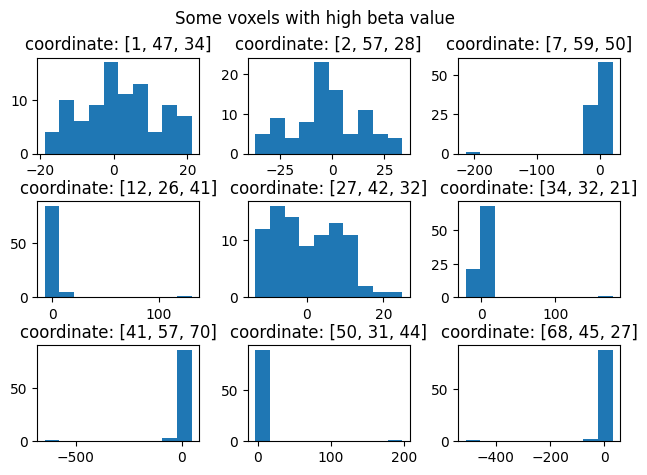

In [11]:
#hist all beta
# plt.figure()
# plt.hist(beta.ravel(), bins=10)
# plt.xlim([-1600, 50]) #(1500, 20)
print(np.nanmin(beta), np.nanmax(beta))

fig, axs = plt.subplots(3,3, layout='constrained')
axs = axs.ravel()
voxels = [10,50,500,1200,4555,6000,8000,10000,-1]
n_coords = len(unique_coords)

for ax, idx in zip(axs, voxels):
    # if not (-n_coords <= idx < n_coords):
    #     ax.set_visible(False)
    #     continue
    i,j,k = unique_coords[idx].astype(int).tolist()
    print(ax, i, j, k)
    ax.hist(beta[i,j,k,:], bins=10)
    ax.set_title(f"coordinate: {[i,j,k]}")

plt.suptitle("Some voxels with high beta value")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.88)
plt.show()

In [39]:
beta_cleaned = np.full(beta.shape, beta, dtype=float)
count = 0
q = 0.90
outlier_mask = np.zeros(beta.shape[:3], dtype=bool)

for i, j, k in np.ndindex(beta.shape[:3]):
    series = beta[i, j, k, :]
    if np.all(np.isnan(series)):
        continue

    med = statistics.median(series)
    mad = stats.median_abs_deviation(series)
    s_v = 1.4826*mad
    s_v = max(s_v, 1e-8)
    z = (series-med)/(s_v)
    absz = np.abs(z)
    tau = np.quantile(absz, q)

    z_clip = np.clip(z, -tau, tau)  
    beta_new = med + s_v * z_clip

    # if np.nanmax(beta_new) >= 20 or np.nanmin(beta_new) <= -20:
    #     print(np.nanmax(beta_new), i, j, k)
    voxel_outliers = np.abs(beta_new) > 20
    if np.any(voxel_outliers):
        outlier_mask[i, j, k] = True
    beta_new = np.where(voxel_outliers, np.nan, beta_new)
    beta_cleaned[i,j,k,:] = beta_new
    # z_clip = np.clip(z, -5, 5)         # or by quantiles
    # beta_cleaned[i,j,k,:] = np.clip(beta_new, -30, 30)
    
    
    # tmp = np.nanmean(beta_cleaned[i,j,k,:])
    # tmp2 = np.nanmax(beta_cleaned[i,j,k,:])
    # if tmp2 >= 30:
    #     print(f"Max value: {tmp2}, Mean: {tmp}, {i},{j},{k}")
        
    # if abs(tmp) >= 30:
    #     beta_cleaned[i,j,k,:] = np.nan
    
    
    # plt.figure()
    # plt.hist(beta[i,j,k,:])
    # plt.title("beta before cleaning")
    # # plt.figure()
    # # plt.hist(z_clip)
    # # plt.title("z value")
    # plt.figure()
    # plt.hist(beta_cleaned[i,j,k,:], bins=10)
    # plt.title("beta after cleaning")
    
    # count += 1
    # if count>=20:
    #     break

print(np.nanmin(beta_cleaned), np.nanmax(beta_cleaned))

# # outlier_map = np.zeros(beta.shape[:3], dtype=float)
# # outlier_map[~outlier_mask] = 1.0
# outlier_img = nib.Nifti1Image(~outlier_mask, A, bold_img.header)
# outlier_view = view_img(outlier_img, bg_img=anat_img, cmap='jet', symmetric_cmap=False,
#                         title=f"Voxels with |beta| <= 20")
# outlier_view.save_as_html(fname := f"normal_beta_voxels_sub{sub}_ses{ses}_run{run}.html")
# outlier_view

save_beta_html(np.nanmean(beta, axis=-1), anat_img, bold_img, A, '', fname = f"raw_beta{sub}_ses{ses}_run{run}.html")
save_beta_html(np.nanmean(beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"clean_beta{sub}_ses{ses}_run{run}.html")

KeyboardInterrupt: 

In [14]:
import numpy as np
import nibabel as nib
from scipy import stats
from nilearn import plotting, image

# beta: 4D array (X,Y,Z,T) or beta_img.get_fdata()
# A: affine of your BOLD/beta image
# anat_img: background anatomy (Nifti1Image)

beta = np.asarray(beta, dtype=float)  # ensure float

# ---------- 1) Robust per-voxel winsorization (no loops) ----------
q = 0.90
med = np.nanmedian(beta, axis=-1)                         # (X,Y,Z)
mad = stats.median_abs_deviation(beta, axis=-1, nan_policy='omit')  # (X,Y,Z)
s_v = np.maximum(1.4826 * mad, 1e-8)

z = (beta - med[..., None]) / s_v[..., None]              # (X,Y,Z,T)
tau = np.nanquantile(np.abs(z), q, axis=-1)               # (X,Y,Z)
z_clip = np.clip(z, -tau[..., None], tau[..., None])
beta_cleaned = med[..., None] + s_v[..., None] * z_clip   # (X,Y,Z,T)

# ---------- 2) Brain mask to kill non-brain slabs ----------
# "brain" = finite and not all-zero on at least ~10% of frames
# finite = np.isfinite(beta_cleaned)
# nonzero = np.any(beta_cleaned != 0, axis=-1)
# brain_mask = (finite.mean(axis=-1) > 0.9) & (nonzero)     # (X,Y,Z) boolean

# ---------- 3) Voxels whose betas stay within [-20, 20] ----------
# (Use beta_cleaned or swap for the raw beta if you want that criterion on raw values)
inlier_mask = (np.nanmax(np.abs(beta_cleaned), axis=-1) <= 20)  # (X,Y,Z) boolean

# mask_to_plot = inlier_mask & brain_mask                        # keep brain only
mask_to_plot = inlier_mask
beta_cleaned2 = np.full_like(beta_cleaned, np.nan, dtype=float)
beta_cleaned2[mask_to_plot] = beta_cleaned[mask_to_plot]
beta_cleaned = beta_cleaned2

# ---------- 4) Build an ROI image and overlay on anatomy ----------
roi_img = nib.Nifti1Image(mask_to_plot.astype(np.uint8), A)

# If anatomy and functional grids differ, resample with nearest neighbor:
roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')

view = plotting.view_img(
    roi_img, bg_img=anat_img,
    threshold=0.5,          # show only '1's
    opacity=0.8,              # transparency of the overlay
    cmap='YlGn',          # single-hue works better for ROIs than 'jet'
    title="Voxels with |beta| ≤ 20"
)
view.save_as_html(f"normal_beta_voxels_sub{sub}_ses{ses}_run{run}.html")

# save_beta_html(np.nanmean(beta, axis=-1), anat_img, bold_img, A, '', fname = f"raw_beta{sub}_ses{ses}_run{run}.html")
# save_beta_html(np.nanmean(beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"clean_beta{sub}_ses{ses}_run{run}.html")


/tmp/ipykernel_324750/1276611059.py:14: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(beta, axis=-1)                         # (X,Y,Z)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/tmp/ipykernel_324750/1276611059.py:31: RuntimeWarning: All-NaN slice encountered
  inlier_mask = (np.nanmax(np.abs(beta_cleaned), axis=-1) <= 20)  # (X,Y,Z) boolean
/tmp/ipykernel_324750/1276611059.py:43: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')
/tmp/ipykernel_324750/1276611059.py:43: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use

Voxels with ≥1 NaN trial: 254347/1813320 (14.03%)
Voxels with all trials NaN: 254347/1813320 (14.03%)


Text(0.5, 1.0, 'beta after cleaning')

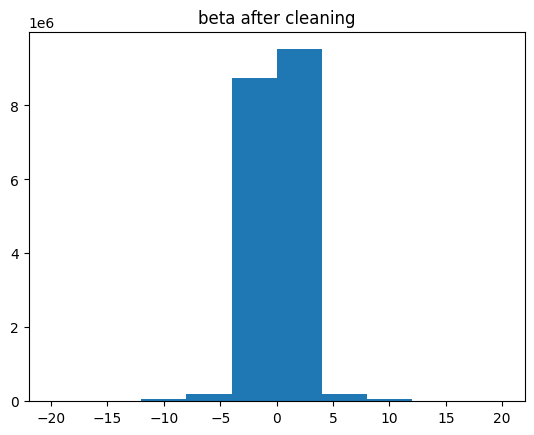

In [15]:
trial_axis = 0  # set to 1 if shape is (n_voxels, n_trials)
voxel_axis = 1 - trial_axis

isnan = np.isnan(beta_cleaned)
vox_any_nan = np.any(isnan, axis=-1)
vox_all_nan = np.all(isnan, axis=-1)

n_voxels = beta_cleaned[:3].size
count_any = int(np.count_nonzero(vox_any_nan))
count_all = int(np.count_nonzero(vox_all_nan))

print(f"Voxels with ≥1 NaN trial: {count_any}/{n_voxels} ({count_any/n_voxels:.2%})")
print(f"Voxels with all trials NaN: {count_all}/{n_voxels} ({count_all/n_voxels:.2%})")

plt.figure()
plt.hist(beta_cleaned.ravel(), bins=10)
plt.title("beta after cleaning")


In [16]:
save_beta_html(np.nanmean(beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"cleaned_beta{sub}_ses{ses}_run{run}.html")

/tmp/ipykernel_319983/1662089557.py:1: RuntimeWarning: Mean of empty slice
  save_beta_html(np.nanmean(beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"cleaned_beta{sub}_ses{ses}_run{run}.html")
/tmp/ipykernel_319983/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/pyth

vmin: -1.7140980914831163, vmax:1.6611923373788553


In [17]:
# print(f"Beta Range: {np.nanmin(beta_cleaned)}, {np.nanmin(beta_cleaned)}")
# print(f"selected_trial: {fmt(np.count_nonzero(~np.isnan(beta_cleaned))/beta.size)}%")
# print(f"selected_voxel(mean): {fmt(np.count_nonzero(~np.isnan(np.nanmean(beta_cleaned, axis=-1)))/beta[:3].size)}%")

# plt.figure()
# plt.hist(beta_cleaned.ravel(), bins=10)
# plt.title("beta after cleaning")

Method 1

In [16]:
def voxelwise_ttest_fdr(betas4d, alpha=0.05, alternative='two-sided'):
    X, Y, Z, T = betas4d.shape
    V = X * Y * Z
    B = betas4d.reshape(V, T)
    
    n  = np.sum(~np.isnan(B), axis=1)
    m  = np.nanmean(B, axis=1)
    s  = np.nanstd(B, axis=1, ddof=1)
    valid = s> 1e-8
    tvals = np.full(V, np.nan)
    df    = np.maximum(n - 1, 0)
    print(np.nanmin(s[valid]), np.nanmax(s[valid]))
    tvals[valid] = m[valid] / (s[valid] / np.sqrt(n[valid]))

    # p-values
    pvals = np.full(V, np.nan)
    if alternative == 'two-sided':
        pvals[valid] = 2.0 * stats.t.sf(np.abs(tvals[valid]), df[valid])
    elif alternative == 'greater':  # H1: mean > 0
        pvals[valid] = stats.t.sf(tvals[valid], df[valid])
    elif alternative == 'less':     # H1: mean < 0
        pvals[valid] = stats.t.cdf(tvals[valid], df[valid])
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    # FDR (Benjamini–Hochberg) across the tested voxels only
    tested = np.isfinite(pvals)
    qvals  = np.full(V, np.nan)
    reject = np.zeros(V, dtype=bool)

    if np.any(tested):
        rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')
        reject[tested] = rej
        qvals[tested]  = q

    # Pack results back to 3D
    out = {
        'tmap'   : tvals.reshape(X, Y, Z),
        'pmap'   : pvals.reshape(X, Y, Z),
        'qmap'   : qvals.reshape(X, Y, Z),
        'reject' : reject.reshape(X, Y, Z),  # True = significant at FDR q<=alpha
        'df'     : df.reshape(X, Y, Z),
        'n'      : n.reshape(X, Y, Z),
    }
    return out

In [18]:
fdr_out = voxelwise_ttest_fdr(beta_cleaned)
mask = fdr_out['reject']

roi_img = nib.Nifti1Image(mask.astype(np.uint8), A)

# If anatomy and functional grids differ, resample with nearest neighbor:
roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')

view = plotting.view_img(
    roi_img, bg_img=anat_img,
    threshold=0.5,          # show only '1's
    opacity=0.8,              # transparency of the overlay
    cmap='YlGn',          # single-hue works better for ROIs than 'jet'
    title="Active Voxels"
)
view.save_as_html(f"binary_ttest_beta_voxels_sub{sub}_ses{ses}_run{run}.html")

/tmp/ipykernel_324750/677545838.py:7: RuntimeWarning: Mean of empty slice
  m  = np.nanmean(B, axis=1)


0.004287854524059121 12.08303289755101


/tmp/ipykernel_324750/4228374586.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')
/tmp/ipykernel_324750/4228374586.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_324750/4228374586.py:9: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unex

In [ ]:
# fdr_out = voxelwise_ttest_fdr(beta_cleaned)

beta_cleaned_ttest = np.full(beta_cleaned.shape, np.nan, dtype=float)
mask = fdr_out['reject']
beta_cleaned_ttest[mask] = beta_cleaned[mask] 

# save_beta_html(np.nanmean(beta_cleaned_ttest, axis=-1), anat_img, bold_img, A, '', fname = f"ttest_beta{sub}_ses{ses}_run{run}.html")

In [20]:
print(f"tmap: {np.nanmin(fdr_out['tmap'])}, {np.nanmax(fdr_out['tmap']), {np.nanmean(fdr_out['tmap'])}}")
print(f"pmap: {np.nanmin(fdr_out['pmap'])}, {np.nanmax(fdr_out['pmap']), {np.nanmean(fdr_out['pmap'])}}")
print(f"qmap: {np.nanmin(fdr_out['qmap'])}, {np.nanmax(fdr_out['qmap']), {np.nanmean(fdr_out['qmap'])}}")

tmap: -2529.001862283695, (np.float64(1475.3824191801048), {np.float64(0.5939440020226118)})
pmap: 6.473515709770779e-218, (np.float64(0.9999132105248971), {np.float64(0.16178697353136734)})
qmap: 1.3621960167442258e-212, (np.float64(0.9999132105248971), {np.float64(0.1874546907938964)})


In [21]:
print(f"selected_trial: {fmt(np.count_nonzero(~np.isnan(beta_cleaned_ttest))/beta.size)}%")
print(f"selected_voxel(mean): {fmt(np.count_nonzero(~np.isnan(np.nanmean(beta_cleaned_ttest, axis=-1)))/beta[:3].size)}%")

selected_trial: 0.261%
selected_voxel(mean): 0.067%


/tmp/ipykernel_319983/10508182.py:2: RuntimeWarning: Mean of empty slice
  print(f"selected_voxel(mean): {fmt(np.count_nonzero(~np.isnan(np.nanmean(beta_cleaned_ttest, axis=-1)))/beta[:3].size)}%")


In [23]:
isnan = np.isnan(beta_cleaned_ttest)
vox_any_nan = np.any(isnan, axis=-1)
vox_all_nan = np.all(isnan, axis=-1)

n_voxels = beta_cleaned_ttest[:3].size
count_any = int(np.count_nonzero(vox_any_nan))
count_all = int(np.count_nonzero(vox_all_nan))

print(f"Voxels with ≥1 NaN trial: {count_any}/{n_voxels} ({count_any/n_voxels:.2%})")
print(f"Voxels with all trials NaN: {count_all}/{n_voxels} ({count_all/n_voxels:.2%})")

Voxels with ≥1 NaN trial: 342701/1813320 (18.90%)
Voxels with all trials NaN: 342473/1813320 (18.89%)


Method 2

In [20]:
def hampel_filter_image(image, window_size, threshold_factor):
    filtered_image = np.copy(image).astype(float)
    rows, cols, depth, time = image.shape
    
    for t in range(time):
        for r in range(window_size // 2, rows - window_size // 2):
            for c in range(window_size // 2, cols - window_size // 2):
                for d in range(window_size // 2, depth - window_size //2):
                    if ~np.isnan(image[r, c, d, t]):
                        window = image[r - window_size // 2 : r + window_size // 2 + 1,
                                    c - window_size // 2 : c + window_size // 2 + 1,
                                    d - window_size // 2 : d + window_size // 2 + 1, t]
                        window_median = np.nanmedian(window)
                        mad = np.nanmedian(np.abs(window - window_median))
                        scaled_mad = 1.4826 * mad # Assuming Gaussian data for scaling factor
                        if np.abs(image[r, c, d, t] - window_median) > threshold_factor * scaled_mad:
                            filtered_image[r, c, d, t] = np.nan
                            
    return filtered_image

In [21]:
filtered_beta_cleaned = hampel_filter_image(beta_cleaned, window_size=5, threshold_factor=3)

roi_img = nib.Nifti1Image(mask.astype(np.uint8), A)

# If anatomy and functional grids differ, resample with nearest neighbor:
roi_img = image.resample_to_img(roi_img, anat_img, interpolation='nearest')

view = plotting.view_img(
    roi_img, bg_img=anat_img,
    threshold=0.5,          # show only '1's
    opacity=0.8,              # transparency of the overlay
    cmap='YlGn',          # single-hue works better for ROIs than 'jet'
    title="Active Voxels"
)
view.save_as_html(f"binary_ttest_beta_voxels_sub{sub}_ses{ses}_run{run}.html")

KeyboardInterrupt: 

In [26]:
isnan = np.isnan(filtered_beta_cleaned)
vox_any_nan = np.any(isnan, axis=-1)
vox_all_nan = np.all(isnan, axis=-1)

n_voxels = filtered_beta_cleaned[:3].size
count_any = int(np.count_nonzero(vox_any_nan))
count_all = int(np.count_nonzero(vox_all_nan))

print(f"Voxels with ≥1 NaN trial: {count_any}/{n_voxels} ({count_any/n_voxels:.2%})")
print(f"Voxels with all trials NaN: {count_all}/{n_voxels} ({count_all/n_voxels:.2%})")

Voxels with ≥1 NaN trial: 298510/1813320 (16.46%)
Voxels with all trials NaN: 252980/1813320 (13.95%)


In [27]:
save_beta_html(np.nanmean(filtered_beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"spatial_filtered_beta{sub}_ses{ses}_run{run}.html")

vmin: -0.6916436705484109, vmax:0.8063249461994655


/tmp/ipykernel_319983/778202559.py:1: RuntimeWarning: Mean of empty slice
  save_beta_html(np.nanmean(filtered_beta_cleaned, axis=-1), anat_img, bold_img, A, '', fname = f"spatial_filtered_beta{sub}_ses{ses}_run{run}.html")
/tmp/ipykernel_319983/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_g

In [28]:
print(f"selected_trial: {fmt(np.count_nonzero(~np.isnan(filtered_beta_cleaned))/beta.size)}%")
print(f"selected_voxel(mean): {fmt(np.count_nonzero(~np.isnan(np.nanmean(filtered_beta_cleaned, axis=-1)))/beta[:3].size)}%")

selected_trial: 0.411%
selected_voxel(mean): 0.116%


/tmp/ipykernel_319983/29680945.py:2: RuntimeWarning: Mean of empty slice
  print(f"selected_voxel(mean): {fmt(np.count_nonzero(~np.isnan(np.nanmean(filtered_beta_cleaned, axis=-1)))/beta[:3].size)}%")


In [29]:
np.count_nonzero(~np.isnan(np.nanmean(filtered_beta_cleaned, axis=-1)))

/tmp/ipykernel_319983/479726783.py:1: RuntimeWarning: Mean of empty slice
  np.count_nonzero(~np.isnan(np.nanmean(filtered_beta_cleaned, axis=-1)))


210424

Method 3

In [30]:
fdr_out = voxelwise_ttest_fdr(filtered_beta_cleaned)

filtered_beta_cleaned_ttest = np.full(filtered_beta_cleaned.shape, np.nan, dtype=float)
mask = fdr_out['reject']
filtered_beta_cleaned_ttest[mask] = filtered_beta_cleaned[mask] 

/tmp/ipykernel_319983/677545838.py:7: RuntimeWarning: Mean of empty slice
  m  = np.nanmean(B, axis=1)


0.004416193466684619 11.752648677711361


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [31]:
isnan = np.isnan(filtered_beta_cleaned_ttest)
vox_any_nan = np.any(isnan, axis=-1)
vox_all_nan = np.all(isnan, axis=-1)

n_voxels = filtered_beta_cleaned_ttest[:3].size
count_any = int(np.count_nonzero(vox_any_nan))
count_all = int(np.count_nonzero(vox_all_nan))

print(f"Voxels with ≥1 NaN trial: {count_any}/{n_voxels} ({count_any/n_voxels:.2%})")
print(f"Voxels with all trials NaN: {count_all}/{n_voxels} ({count_all/n_voxels:.2%})")

save_beta_html(np.nanmean(filtered_beta_cleaned_ttest, axis=-1), anat_img, bold_img, A, '', fname = f"ttest_spatial_filtered_beta{sub}_ses{ses}_run{run}.html")

Voxels with ≥1 NaN trial: 373735/1813320 (20.61%)
Voxels with all trials NaN: 351242/1813320 (19.37%)
vmin: -0.8927145769208391, vmax:1.053482093786292


/tmp/ipykernel_319983/1503058544.py:12: RuntimeWarning: Mean of empty slice
  save_beta_html(np.nanmean(filtered_beta_cleaned_ttest, axis=-1), anat_img, bold_img, A, '', fname = f"ttest_spatial_filtered_beta{sub}_ses{ses}_run{run}.html")
/tmp/ipykernel_319983/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_319983/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian

Compute Diff and fit guassian dist

(69, 92, 73, 89)
beta_clean_diff: -33.75160789489746, 32.93133354187012


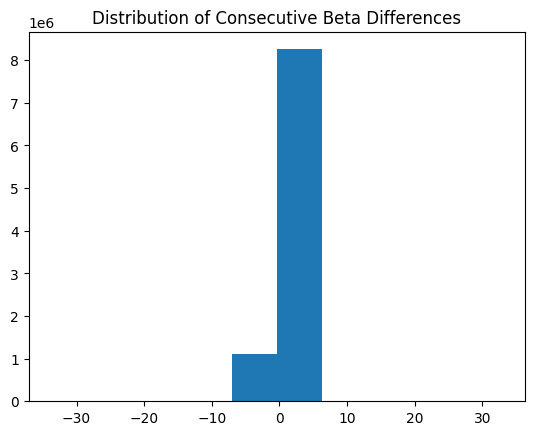

In [32]:
beta_cleaned_diff = np.diff(filtered_beta_cleaned_ttest, axis=-1)
print(beta_cleaned_diff.shape)
print(f"beta_clean_diff: {np.nanmin(beta_cleaned_diff.ravel())}, {np.nanmax(beta_cleaned_diff.ravel())}")

plt.figure()
plt.hist(beta_cleaned_diff.ravel(), bins=10)
plt.title("Distribution of Consecutive Beta Differences")
plt.show()

In [33]:
beta_cleaned_diff_reshape = beta_cleaned_diff.reshape(-1, beta_cleaned_diff.shape[-1])
mask = ~np.all(np.isnan(beta_cleaned_diff_reshape), axis=1)
beta_diff_clean = beta_cleaned_diff_reshape[mask]

In [34]:
print(np.sum(np.isnan(beta_diff_clean)))
print(beta_diff_clean.size)
46496/18728448*100

602920
9969513


0.24826403127477512

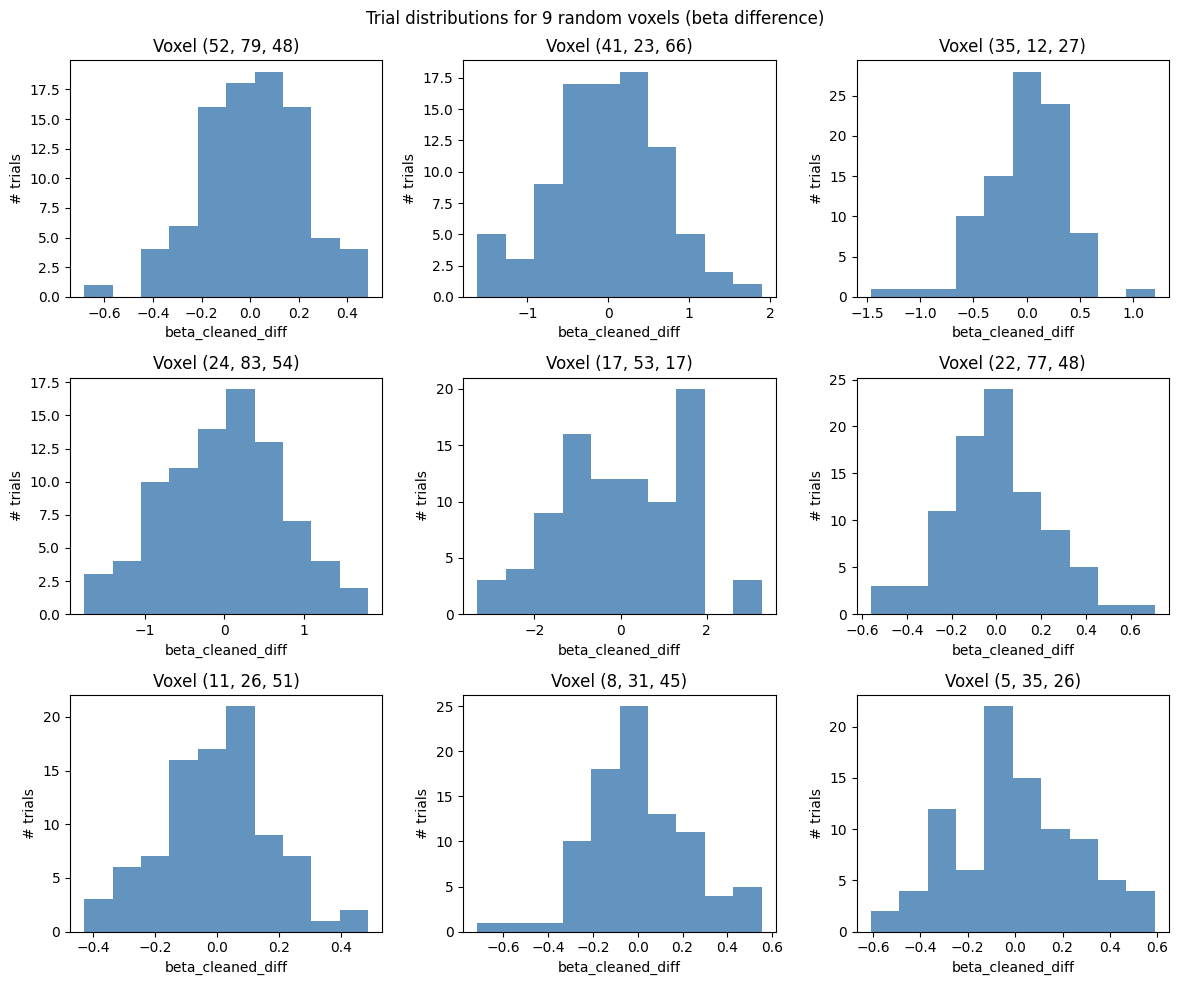

In [38]:
rng = np.random.default_rng(0)
n_pick = min(9, beta_diff_clean.shape[0])
picked_rows = rng.choice(beta_diff_clean.shape[0], size=n_pick, replace=False)

flat_idx_all = np.where(mask)[0]
orig_flat_idx = flat_idx_all[picked_rows]
coords = np.array(np.unravel_index(orig_flat_idx, beta_cleaned_diff.shape[:-1])).T  # (n_pick, 3)

# Plot 3x3 histograms
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.ravel()

for i in range(9):
    ax = axes[i]
    if i < n_pick:
        vals = beta_diff_clean[picked_rows[i]]
        vals = vals[~np.isnan(vals)]
        ax.hist(vals, bins=10, color='steelblue', alpha=0.85)
        c = tuple(int(x) for x in coords[i])
        ax.set_title(f'Voxel {c}')
        ax.set_xlabel('beta_cleaned_diff')
        ax.set_ylabel('# trials')
    else:
        ax.axis('off')

fig.suptitle('Trial distributions for 9 random voxels (beta difference)')
fig.tight_layout()
plt.show()

In [22]:
sk = skew(beta_diff_clean, axis=1, bias=False)     
kt = kurtosis(beta_diff_clean, axis=1, fisher=False, bias=False)

sk_thr = np.nanpercentile(np.abs(sk), 99)         
kt_thr = np.nanpercentile(np.abs(kt - 3), 99)            
mask_gaussian_like = (np.abs(sk) < sk_thr) & (np.abs(kt - 3) < kt_thr)

# now pick the least-variable among those
stds = np.nanstd(beta_diff_clean, axis=1, ddof=1)
low_var_mask = mask_gaussian_like & (stds < np.nanpercentile(stds[mask_gaussian_like], 25))  # e.g., lowest quartile

low_var_beta = np.full_like(beta_diff_clean, np.nan, dtype=float)
low_var_beta[low_var_mask] = beta_diff_clean[low_var_mask]


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
vol_shape = filtered_beta_cleaned_ttest.shape[:-1]   # (X, Y, Z)
flat_idx_all = np.where(mask)[0]                     # rows kept when building beta_diff_clean
selected_rows = np.where(low_var_mask)[0]            # rows selected within beta_diff_clean
orig_flat_idx = flat_idx_all[selected_rows]          # original flat indices in 3D volume
coords = np.unravel_index(orig_flat_idx, vol_shape)  # tuple of (i, j, k)

# Option A: visualize mean of low_var_beta differences per voxel
low_var_vals = np.nanmean(low_var_beta[selected_rows], axis=1)  # one value per selected voxel
low_var_map = np.full(vol_shape, np.nan, dtype=float)
low_var_map[coords] = low_var_vals
out_name_a = f"low_var_beta_diff_mean{sub}_ses{ses}_run{run}.html" if all(v in globals() for v in ['sub','ses','run']) else "low_var_beta_diff_mean.html"
save_beta_html(low_var_map, anat_img, bold_img, A, '', fname=out_name_a)
print(f"Saved: {out_name_a}")


/tmp/ipykernel_310544/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


vmin: -0.003426679181918669, vmax:0.0036378101267841453
Saved: low_var_beta_diff_mean04_ses1_run1.html


In [45]:
print(sk_thr)

0.7162653863945659


Text(3, -2, '5.425')

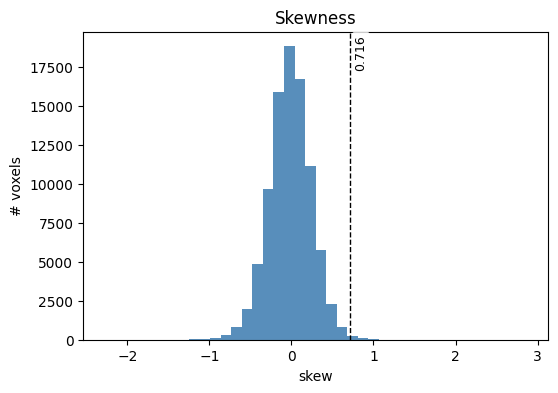

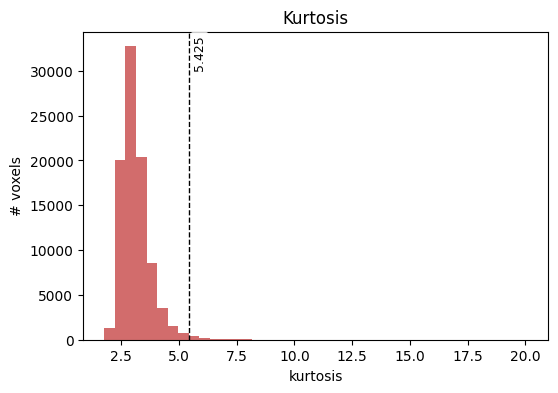

In [55]:
plt.figure(figsize=(6, 4))
plt.hist(sk, bins=40, color='steelblue', alpha=0.9)
plt.title('Skewness')
plt.xlabel('skew')
plt.ylabel('# voxels')
plt.axvline(sk_thr, color='k', linestyle='--', linewidth=1)
ax = plt.gca()
fmt = '{:.3f}'
ax.annotate(fmt.format(sk_thr),
            xy=(sk_thr, 1), xycoords=('data', 'axes fraction'),
                xytext=(3, -2), textcoords='offset points',
                rotation=90, va='top', ha='left',
                fontsize=9, color='k',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8))


plt.figure(figsize=(6, 4))
plt.hist(kt, bins=40, color='indianred', alpha=0.9)
plt.title('Kurtosis')
plt.xlabel('kurtosis')
plt.ylabel('# voxels')
plt.axvline(kt_thr+3, color='k', linestyle='--', linewidth=1)
ax = plt.gca()
ax.annotate(fmt.format(kt_thr+3),
            xy=(kt_thr+3, 1), xycoords=('data', 'axes fraction'),
                xytext=(3, -2), textcoords='offset points',
                rotation=90, va='top', ha='left',
                fontsize=9, color='k',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8))


In [34]:
coords

(array([ 2,  2,  3, ..., 67, 67, 67], shape=(22061,)),
 array([42, 43, 28, ..., 40, 40, 40], shape=(22061,)),
 array([31, 31, 35, ..., 31, 32, 33], shape=(22061,)))

In [ ]:
vol_shape = filtered_beta_cleaned_ttest.shape[:-1]   # (X, Y, Z)
flat_idx_all = np.where(mask)[0]                     # rows kept when building beta_diff_clean
selected_rows = np.where(low_var_mask)[0]            # rows selected within beta_diff_clean
orig_flat_idx = flat_idx_all[selected_rows]          # original flat indices in 3D volume
coords = np.unravel_index(orig_flat_idx, vol_shape)  # tuple of (i, j, k)

# Option A: visualize mean of low_var_beta differences per voxel
low_var_vals = np.nanmean(low_var_beta[selected_rows], axis=1)  # one value per selected voxel
low_var_map = np.full(vol_shape, np.nan, dtype=float)
low_var_map[coords] = low_var_vals
out_name_a = f"low_var_beta_diff_mean{sub}_ses{ses}_run{run}.html" if all(v in globals() for v in ['sub','ses','run']) else "low_var_beta_diff_mean.html"
save_beta_html(low_var_map, anat_img, bold_img, A, '', fname=out_name_a)
print(f"Saved: {out_name_a}")


/tmp/ipykernel_310544/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


vmin: -0.003426679181918669, vmax:0.0036378101267841453
Saved: low_var_beta_diff_mean04_ses1_run1.html


In [ ]:
vol_shape = filtered_beta_cleaned_ttest.shape[:-1]   # (X, Y, Z)
flat_idx_all = np.where(mask)[0]                     # rows kept when building beta_diff_clean
selected_rows = np.where(low_var_mask)[0]            # rows selected within beta_diff_clean
orig_flat_idx = flat_idx_all[selected_rows]          # original flat indices in 3D volume
coords = np.unravel_index(orig_flat_idx, vol_shape)  # tuple of (i, j, k)

# Option A: visualize mean of low_var_beta differences per voxel
low_var_vals = np.nanmean(low_var_beta[selected_rows], axis=1)  # one value per selected voxel
low_var_map = np.full(vol_shape, np.nan, dtype=float)
low_var_map[coords] = low_var_vals
out_name_a = f"low_var_beta_diff_mean{sub}_ses{ses}_run{run}.html" if all(v in globals() for v in ['sub','ses','run']) else "low_var_beta_diff_mean.html"
save_beta_html(low_var_map, anat_img, bold_img, A, '', fname=out_name_a)
print(f"Saved: {out_name_a}")


/tmp/ipykernel_310544/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


vmin: -0.003426679181918669, vmax:0.0036378101267841453
Saved: low_var_beta_diff_mean04_ses1_run1.html


In [ ]:
vol_shape = filtered_beta_cleaned_ttest.shape[:-1]   # (X, Y, Z)
flat_idx_all = np.where(mask)[0]                     # rows kept when building beta_diff_clean
selected_rows = np.where(low_var_mask)[0]            # rows selected within beta_diff_clean
orig_flat_idx = flat_idx_all[selected_rows]          # original flat indices in 3D volume
coords = np.unravel_index(orig_flat_idx, vol_shape)  # tuple of (i, j, k)

# Option A: visualize mean of low_var_beta differences per voxel
low_var_vals = np.nanmean(low_var_beta[selected_rows], axis=1)  # one value per selected voxel
low_var_map = np.full(vol_shape, np.nan, dtype=float)
low_var_map[coords] = low_var_vals
out_name_a = f"low_var_beta_diff_mean{sub}_ses{ses}_run{run}.html" if all(v in globals() for v in ['sub','ses','run']) else "low_var_beta_diff_mean.html"
save_beta_html(low_var_map, anat_img, bold_img, A, '', fname=out_name_a)
print(f"Saved: {out_name_a}")


/tmp/ipykernel_310544/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


vmin: -0.003426679181918669, vmax:0.0036378101267841453
Saved: low_var_beta_diff_mean04_ses1_run1.html


In [23]:
vol_shape = filtered_beta_cleaned_ttest.shape[:-1]   # (X, Y, Z)
flat_idx_all = np.where(mask)[0]                     # rows kept when building beta_diff_clean
selected_rows = np.where(low_var_mask)[0]            # rows selected within beta_diff_clean
orig_flat_idx = flat_idx_all[selected_rows]          # original flat indices in 3D volume
coords = np.unravel_index(orig_flat_idx, vol_shape)  # tuple of (i, j, k)

# Option A: visualize mean of low_var_beta differences per voxel
low_var_vals = np.nanmean(low_var_beta[selected_rows], axis=1)  # one value per selected voxel
low_var_map = np.full(vol_shape, np.nan, dtype=float)
low_var_map[coords] = low_var_vals
out_name_a = f"low_var_beta_diff_mean{sub}_ses{ses}_run{run}.html" if all(v in globals() for v in ['sub','ses','run']) else "low_var_beta_diff_mean.html"
save_beta_html(low_var_map, anat_img, bold_img, A, '', fname=out_name_a)
print(f"Saved: {out_name_a}")


/tmp/ipykernel_310544/94407561.py:43: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_310544/94407561.py:43: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


vmin: -0.003426679181918669, vmax:0.0036378101267841453
Saved: low_var_beta_diff_mean04_ses1_run1.html


In [24]:
isnan = np.isnan(low_var_beta)
vox_any_nan = np.any(isnan, axis=-1)
vox_all_nan = np.all(isnan, axis=-1)

n_voxels = filtered_beta_cleaned_ttest[:3].size
count_any = int(np.count_nonzero(vox_any_nan))
count_all = int(np.count_nonzero(vox_all_nan))
n_voxels_select = low_var_beta.shape[0]

print(f"Voxels without any trials NaN: {n_voxels_select-count_all}/{n_voxels} ({(n_voxels_select-count_all)/n_voxels:.2%})")

Voxels without any trials NaN: 22061/1813320 (1.22%)


Optimization Problem

In [25]:
def calculate_matrices(betasmd, selected_voxels, anat_img, affine, masked_bold_data, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    # BOLD_data = bold_img.get_fdata() #(90, 128, 85, 850)
    BOLD_data = masked_bold_data
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20

    print(selected_BOLD_data_reshape.shape)
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]
    print(selected_BOLD_data_subset.shape)

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)


In [26]:
param_grid = {"alpha_var":   [0.5, 1.0], "alpha_smooth":[0.5, 1.0]}
num_trials = 90
trial_len = 9
affine = anat_img.affine

L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(beta, low_var_map, anat_img, affine, bold_img, None, trial_len)

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [30]:
low_var_map[~np.isnan(low_var_map)]

array([-4.44592347e-03, -4.19900064e-03,  1.97027326e-03, ...,
       -5.09324285e-04, -2.01022441e-04, -8.00496239e-05], shape=(22061,))

In [ ]:
def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth):
    """Value of the full loss on a validation set."""
    quad = (w.T @ np.diag(L_task) @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    # l1 = alpha_sparse * np.sum(np.abs(w))
    return quad

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]
    
    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value

def calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = betasmd.shape[-1]

    for a_var, a_smooth in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            clear_console()
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth))
            print(f"fold_scores: {fold_scores}")
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth)

    clear_console()
    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

def select_opt_weight(selected_BOLD_data, weights, selected_voxels, affine):
    y = selected_BOLD_data.T @ weights
    p95 = np.percentile(weights, 95)

    weight_volume = np.zeros(selected_voxels.shape, dtype=np.float32)
    weight_volume[selected_voxels] = weights  # put weights in their voxel positions

    mask = np.zeros(selected_voxels.shape, dtype=bool)
    # Keep only the top 5% strongest weights
    selected_weights = (weights >= p95)
    mask[selected_voxels] = selected_weights
    weight_volume[~mask] = 0

    masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
    weight_img = nib.Nifti1Image(masked_weights, affine=affine)
    
    return weight_img, masked_weights, y

In [ ]:
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)
print(y.shape)

np.save(f"best_params_session{ses}_run{run}.npy", best_params)
np.save(f"masked_weights_session{ses}_run{run}.npy", masked_weights)
np.save(f"all_weights_session{ses}_run{run}.nii", weight_img)
np.save(f"reconstructed_sig_session{ses}_run{run}.npy",y)

In [40]:
# unique_coords.shape[0]/beta[:3].size*100

0.6974499812498621

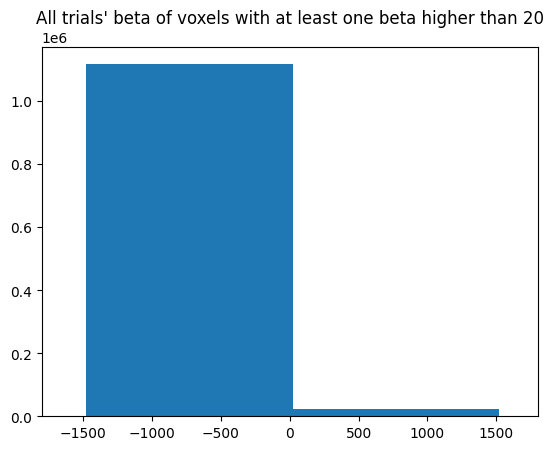

In [54]:
# i, j, k = unique_coords.T.astype(int)
# mask = np.zeros(beta.shape[:3], dtype=bool)
# mask[i,j,k] = True
# selected_beta = beta[mask]

# plt.figure()
# plt.hist(selected_beta.ravel(), bins=10)
# plt.title("All trials' beta of voxels with at least one beta higher than 20")
# plt.xlim([-1800, 1800])
# plt.show()

In [55]:
# coords.shape[0]/beta.size*100

0.11788609698856481

Beta Range: 12023.0693359375, -2978.960693359375, mean: 0.009225452318787575


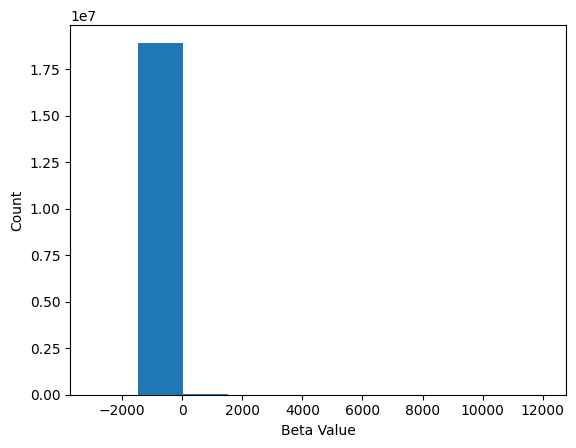

Number of Voxels: 463404, thr: None
Number of Voxels: 342, thr: 10
Number of Voxels: 978, thr: 6
Number of Voxels: 3723, thr: 3


In [6]:
# print(f"Beta Range: {np.nanmax(beta)}, {np.nanmin(beta)}, mean: {np.nanmean(beta)}")
# plot_beta_hist(beta)

# beta_mean = np.mean(beta, axis=-1)

# thr_list = [None, 10, 6, 3]
# for thr in thr_list:
#     if thr is not None:
#         mask = abs(beta_mean) >= thr
#     else:
#         mask = beta_mean
        
#     count = int(np.count_nonzero(mask))
#     print(f"Number of Voxels: {int(count)}, thr: {thr}")


In [7]:
# thr_list = [3, 6, 10]
# for thr in thr_list:
#     beta_outline = np.full(beta_mean.shape, np.nan, dtype=float)
#     mask = beta_mean >= abs(thr)
#     beta_outline[mask] = beta_mean[mask] 
#     save_beta_html(beta_outline, anat_img, bold_img, A, '', f"thr{thr}_outline_beta_sub{sub}_ses{ses}_run1.html")

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Remove based on MeanBeta

In [ ]:
# beta_outline = np.full(beta.shape, np.nan, dtype=float)
# mask = abs(beta_mean)>=10
# beta_outline[~mask,:] = beta[~mask,:]

Remove based on Beta

In [33]:
# bad_vox = (np.abs(beta) >= 10).any(axis=-1)
# beta_clean = np.where(bad_vox[..., None], np.nan, beta.astype(float))
# beta_clean.shape

(69, 92, 73, 90)

In [11]:
# beta_outline = np.full(beta.shape, np.nan, dtype=float)
# mask = abs(beta)>=10
# beta_outline[~mask] = beta[~mask]

# # # mask = mask.any(axis=-1)
# # # R2_outline = np.full(R2.shape, np.nan, dtype=float)
# # # R2_outline[~mask] = R2[~mask]

In [32]:
# coords = np.column_stack(np.where(mask)[:3])   # shape (N, 3), each row = (x, y, z)
# unique_coords = np.unique(coords, axis=0)  # remove duplicates, if any
# unique_coords

array([[ 0, 48, 29],
       [ 0, 49, 30],
       [ 0, 50, 31],
       ...,
       [68, 44, 28],
       [68, 45, 26],
       [68, 45, 27]], shape=(16948, 3))

In [9]:
# print(np.isfinite(beta_mean).sum())
# beta_outline_mean = np.nanmean(beta_outline, axis=-1)
# print(np.isfinite(beta_outline_mean).sum())


210434
210434


/tmp/ipykernel_234500/107563602.py:2: RuntimeWarning: Mean of empty slice
  beta_outline_mean = np.nanmean(beta_outline, axis=-1)


Beta Range: 9.99997615814209, -9.999992370605469, mean: 0.012007109510017782


(array([2.30000e+01, 1.01296e+05, 5.40020e+04, 2.28830e+04, 1.03740e+04,
        3.20800e+03, 1.16200e+03, 4.05000e+02, 1.07000e+02, 1.80000e+01]),
 array([-6.13777208, -1.8972611 ,  2.34324989,  6.58376088, 10.82427187,
        15.06478286, 19.30529385, 23.54580483, 27.78631582, 32.02682681,
        36.2673378 ]),
 <BarContainer object of 10 artists>)

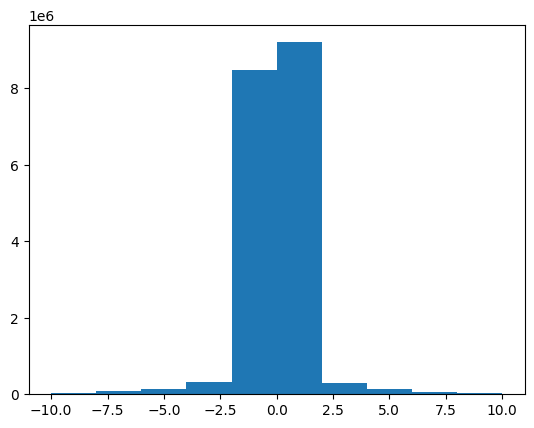

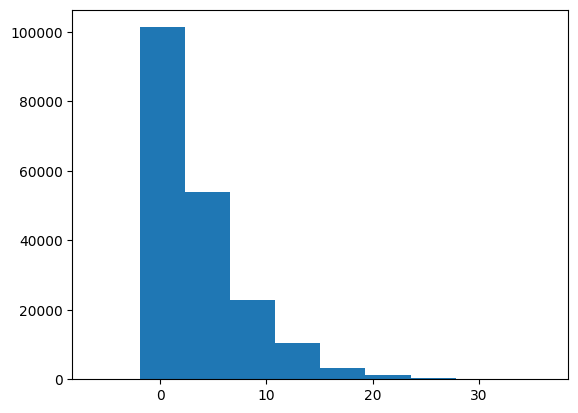

In [17]:
# print(f"Beta Range: {np.nanmax(beta_outline)}, {np.nanmin(beta_outline)}, mean: {np.nanmean(beta_outline)}")
# plt.figure()
# plt.hist(beta_outline.ravel())

# plt.figure()
# plt.hist(R2_outline.ravel())

In [26]:
# def voxelwise_ttest_fdr(betas4d, alpha=0.05, alternative='two-sided'):
#     X, Y, Z, T = betas4d.shape
#     V = X * Y * Z
#     B = betas4d.reshape(V, T)
    
#     n  = np.sum(~np.isnan(B), axis=1)
#     m  = np.nanmean(B, axis=1)
#     s  = np.nanstd(B, axis=1, ddof=1)
#     valid = s> 1e-8
#     tvals = np.full(V, np.nan)
#     df    = np.maximum(n - 1, 0)
#     print(np.nanmin(s[valid]), np.nanmax(s[valid]))
#     tvals[valid] = m[valid] / (s[valid] / np.sqrt(n[valid]))

#     # p-values
#     pvals = np.full(V, np.nan)
#     if alternative == 'two-sided':
#         pvals[valid] = 2.0 * stats.t.sf(np.abs(tvals[valid]), df[valid])
#     elif alternative == 'greater':  # H1: mean > 0
#         pvals[valid] = stats.t.sf(tvals[valid], df[valid])
#     elif alternative == 'less':     # H1: mean < 0
#         pvals[valid] = stats.t.cdf(tvals[valid], df[valid])
#     else:
#         raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

#     # FDR (Benjamini–Hochberg) across the tested voxels only
#     tested = np.isfinite(pvals)
#     qvals  = np.full(V, np.nan)
#     reject = np.zeros(V, dtype=bool)

#     if np.any(tested):
#         rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')
#         reject[tested] = rej
#         qvals[tested]  = q

#     # Pack results back to 3D
#     out = {
#         'tmap'   : tvals.reshape(X, Y, Z),
#         'pmap'   : pvals.reshape(X, Y, Z),
#         'qmap'   : qvals.reshape(X, Y, Z),
#         'reject' : reject.reshape(X, Y, Z),  # True = significant at FDR q<=alpha
#         'df'     : df.reshape(X, Y, Z),
#         'n'      : n.reshape(X, Y, Z),
#     }
#     return out

In [27]:
# fdr_out = voxelwise_ttest_fdr(beta_outline)

/tmp/ipykernel_233628/677545838.py:7: RuntimeWarning: Mean of empty slice
  m  = np.nanmean(B, axis=1)


0.004660956879539112 8.032756924708133


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [24]:
# print(f"tmap: {np.nanmin(fdr_out['tmap'])}, {np.nanmax(fdr_out['tmap']), {np.nanmean(fdr_out['tmap'])}}")
# print(f"pmap: {np.nanmin(fdr_out['pmap'])}, {np.nanmax(fdr_out['pmap']), {np.nanmean(fdr_out['pmap'])}}")
# print(f"qmap: {np.nanmin(fdr_out['qmap'])}, {np.nanmax(fdr_out['qmap']), {np.nanmean(fdr_out['qmap'])}}")

tmap: -2529.001862283695, (np.float64(1475.3824191801048), {np.float64(0.5967331555815854)})
pmap: 6.473515709770779e-218, (np.float64(0.999900318660933), {np.float64(0.16511173081104705)})
qmap: 1.3621960167442258e-212, (np.float64(0.999900318660933), {np.float64(0.19184191368403258)})


In [42]:
# fdr_out = voxelwise_ttest_fdr(beta_outline)

# beta_outline_ttest = np.full(beta_outline.shape, np.nan, dtype=float)
# mask = fdr_out['reject']
# beta_outline_ttest[mask] = beta_outline[mask] 

# beta_outline_mean = np.nanmean(beta_outline, axis=-1)
# beta_outline_ttest_mean = np.nanmean(beta_outline_ttest, axis=-1)

# print(np.isfinite(beta_outline_mean).sum())
# print(np.isfinite(beta_outline_ttest_mean).sum())

210434
119586


/tmp/ipykernel_233628/1643291813.py:5: RuntimeWarning: Mean of empty slice
  beta_outline_mean = np.nanmean(beta_outline, axis=-1)
/tmp/ipykernel_233628/1643291813.py:6: RuntimeWarning: Mean of empty slice
  beta_outline_ttest_mean = np.nanmean(beta_outline_ttest, axis=-1)


In [43]:
# save_beta_html(beta_outline_mean, anat_img, bold_img, A, '', f"outline_beta_sub{sub}_ses{ses}_run1.html")
# save_beta_html(beta_outline_ttest_mean, anat_img, bold_img, A, '', f"selected_beta_sub{sub}_ses{ses}_run1.html")

/tmp/ipykernel_233628/3501961089.py:37: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_233628/3501961089.py:37: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_233628/3501961089.py:37: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin

In [46]:
# def hampel_filter_image(image, window_size, threshold_factor):
#     filtered_image = np.copy(image).astype(float)
#     rows, cols, depth = image.shape

#     for r in range(window_size // 2, rows - window_size // 2):
#         for c in range(window_size // 2, cols - window_size // 2):
#             for d in range(window_size // 2, depth - window_size //2):
#                 window = image[r - window_size // 2 : r + window_size // 2 + 1,
#                                c - window_size // 2 : c + window_size // 2 + 1,
#                                d - window_size // 2 : d + window_size // 2 + 1]

#                 window_median = np.nanmedian(window)
#                 mad = np.nanmedian(np.abs(window - window_median))
#                 scaled_mad = 1.4826 * mad # Assuming Gaussian data for scaling factor

#                 if image[r, c, d] is not None:
#                     if np.abs(image[r, c, d] - window_median) > threshold_factor * scaled_mad:
#                         filtered_image[r, c, d] = np.nan
#     return filtered_image

# filtered_image_ttest = hampel_filter_image(beta_outline_ttest_mean, window_size=5, threshold_factor=3)
# filtered_image = hampel_filter_image(beta_outline_mean, window_size=5, threshold_factor=3)

In [52]:
# filtered_image_ttest = hampel_filter_image(beta_outline_ttest_mean, window_size=5, threshold_factor=3)
# filtered_image = hampel_filter_image(beta_outline_mean, window_size=5, threshold_factor=3)

/tmp/ipykernel_233628/2898989558.py:12: RuntimeWarning: All-NaN slice encountered
  window_median = np.nanmedian(window)
/tmp/ipykernel_233628/2898989558.py:13: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(window - window_median))


In [56]:
# print(np.isfinite(beta_mean).sum())

# print(np.isfinite(beta_outline_mean).sum())
# print(np.isfinite(filtered_image).sum())

# print(np.isfinite(beta_outline_ttest_mean).sum())
# print(np.isfinite(filtered_image_ttest).sum())

210434
210434
187150
119586
107135


In [54]:
# save_beta_html(filtered_image, anat_img, bold_img, A, '', f"filtered_selected_beta_sub{sub}_ses{ses}_run1.html")

/tmp/ipykernel_233628/3501961089.py:37: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/tmp/ipykernel_233628/3501961089.py:37: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(beta_on_anat, bg_img=anat_img, cmap='seismic', symmetric_cmap=False, vmax=vmax, vmin=vmin, threshold=thr,
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [29]:
import os
import shutil

def copy_html_files(src_folder, dst_folder):
    # Make sure the destination folder exists
    os.makedirs(dst_folder, exist_ok=True)

    # Walk through the source folder
    for root, dirs, files in os.walk(src_folder):
        for file in files:
            if file.endswith(".html"):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(dst_folder, file)

                # Copy the file
                shutil.copy2(src_path, dst_path)
                print(f"Copied: {src_path} -> {dst_path}")

# Example usage:
src_folder = "/home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new"   # Change this to your folder
dst_folder = "/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/"  # Change this to where you want files saved

copy_html_files(src_folder, dst_folder)


Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin7_sub04_ses1_run2_window7.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin7_sub04_ses1_run2_window7.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin8_sub04_ses1_run2.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin8_sub04_ses1_run2.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/Final_voxels_(without_nan_outlier_low_R2)_sub04_ses1_run2_window5.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/Final_voxels_(without_nan_outlier_low_R2)_sub04_ses1_run2_window5.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin3_sub04_ses1_run1_window5.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin3_sub04_ses1_run1_window5.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin9_sub04_